# Cloning repository and installing libraries

In [ ]:
!git clone https://github.com/mskv99/Defect-Detection.git

Cloning into 'Defect-Detection'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 285 (delta 103), reused 58 (delta 29), pack-reused 98
Receiving objects: 100% (285/285), 199.46 MiB | 27.08 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
%cd /content/Defect-Detection/NetDirectory/
!pwd

/content/Defect-Detection/NetDirectory
/content/Defect-Detection/NetDirectory


In [ ]:
#download last version of dataset

!curl -L 'https://app.roboflow.com/ds/WY3Kia0nPR?key=FhUQWiFiXI' > roboflow.zip; unzip roboflow.zip -d custom_data;rm roboflow.zip

In [ ]:
!pip install wandb


In [ ]:
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo

In case you want to log your experiment provide a logging system such as `Weights and Biases`. Log with your `API KEY`. Import the library. Initialize the config with the parameters of the experiment.

In [ ]:
!wandb login

#api key for weights and biases: 7f7117ef2660f827c823ba03863048fe0eea4801

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="FasterRCNN",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.007475,
    "architecture": "resnet50_fpn_v2",
    "dataset": "Defect_dataset_v6",
    "epochs": 40,
    "optimizer" : "SGD",
    "batch_size" : "8",
    "augmentations" : 'blur',
    "scheduler" : 'step_lr_10_ep_gamma_0.1'
    }
)


wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
import glob as glob
from google.colab.patches import cv2_imshow
from torch.utils.tensorboard import SummaryWriter

from xml.etree import ElementTree as et
import random
from torch.utils.data import Dataset, DataLoader

from custom_utils import (
    SaveBestModel,
    save_model,
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

import matplotlib.pyplot as plt
import time
import os
import pandas as pd




def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

Import modules from `NetDirectory`.

**`test_inference`** function allows you to make predictions on your test set. It creates `inference_outputs/images` directory and saves predictions within this directory. The reqired arugements:

*   DIR_TEST - path to your test images
*   CLASSES - LIST of classes you defined in `config.py`
*   model - your trained model
*   CONF_THRESHOLD - threshold to filter out bounding boxes with low confidence score. By default goes 0.5


**`per_class_stat`** function allows you to evalaute your model on validation or test set and get the per class Precision, Recall, mAP metrics under the defined IoU threshold level. Function saves the results to '.csv' file.The required arguments:
* valid_loader - there can be validation or test data loader instance
* model - traiend model
* classes - LIST of classes you defined in `config.py`
* save_path - provied the path with the name of '.csv' file where you want to save your metrics
* metric - create a metric object via `MeanAveragePrecision` class and provide this metric as an argument to command. For more details read [https://torchmetrics.readthedocs.io/en/v0.8.2/detection/mean_average_precision.html](https://)

**`validate`** function is used in training process to evaluate your model during training process and in the `per_class_stat` function. The required arguments:
* valid_data_loader - validation data loader instance
* model - model instance. Either one that is being trained or already trained depending on your purposes.
* metric - metric object.




In [ ]:
from inference import test_inference, per_class_stat
from eval import validate

# Creating dataset class and applying transforms


In [ ]:
#from datasets import *
from datasets import CustomDataset, plot_box, show_tranformed_image
from config import (BATCH_SIZE, RESIZE_TO, NUM_WORKERS,
                    NUM_EPOCHS, LEARNING_RATE, DEVICE,
                    TRAIN_DIR, VALID_DIR, TEST_DIR, CLASSES,
                    NUM_CLASSES, OUT_DIR, COLORS, STEP
                    )

dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO,CLASSES, transforms = None
)
print(f"Number of training images: {len(dataset)}")

Number of training images: 380


In [ ]:
OUT_DIR

'/content/Defect-Detection/NetDirectory/outputs'

In [ ]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Define the training tranforms.
def get_train_transform():
    return A.Compose([
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
        ], p=0.5),
        A.ToGray(p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })


In [ ]:

# Prepare the final datasets and data loaders.
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0, B_SIZE = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size = B_SIZE,
        shuffle=True,
        num_workers = num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0, B_SIZE = BATCH_SIZE):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size = B_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return valid_loader


# sanity check of the Dataset pipeline with sample visualization
dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO,CLASSES, transforms = None
)
print(f"Number of training images: {len(dataset)}")



Number of training images: 380


In [ ]:
# Function to plot images with the bounding boxes.
def plot(random_list):


    plt.figure(figsize=(8, 8))



    for idx, img in enumerate(random_list):
      image, target = dataset[img]
      result_image = plot_box(image, target)
      plt.subplot(2, 2, idx+1)
      plt.imshow(result_image.astype('uint8'))
      plt.axis('off')
    plt.tight_layout()
    plt.show()


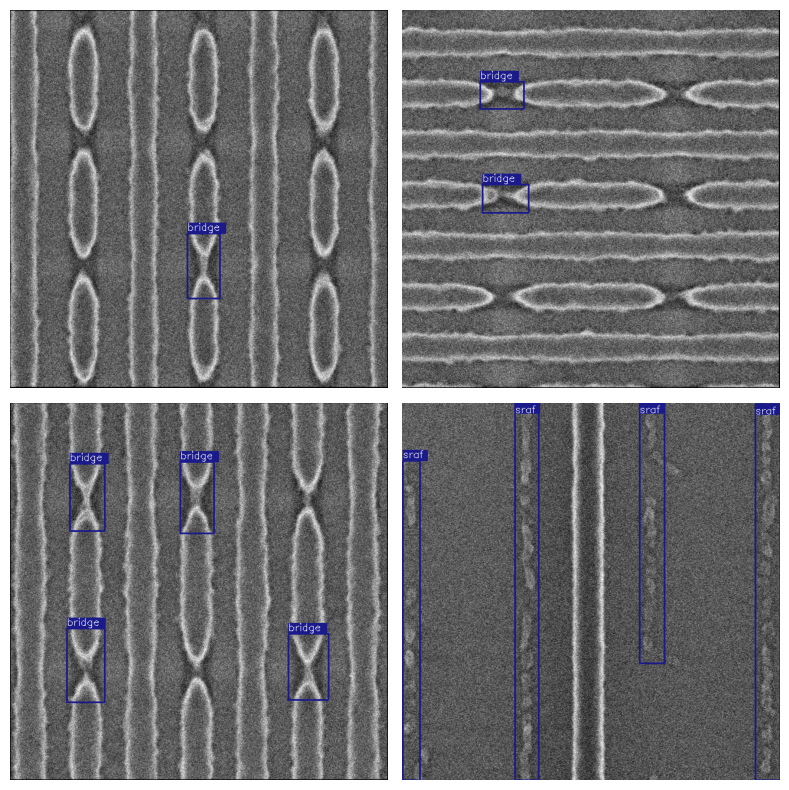

In [ ]:
random_numb = random.sample(range(0,len(dataset)), 4)
plot(random_numb)

In [ ]:
train_dataset = create_train_dataset(TRAIN_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)

valid_dataset = create_valid_dataset(VALID_DIR)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)

test_dataset = create_valid_dataset(TEST_DIR)
test_loader = create_valid_loader(test_dataset, NUM_WORKERS)

In [ ]:
show_tranformed_image(train_loader, DEVICE, CLASSES, COLORS)


# Creating a model and defining optimizer


In [ ]:
import sys

sys.path.append('/content/Defect-Detection/NetDirectory/models/faster_rcnn')

#import fasterrcnn_resnet101
import fasterrcnn_resnet50_fpn_v2
#import fasterrcnn_mobilenetv3_large_fpn
#import fasterrcnn_resnet152.py

#from fasterrcnn_resnet101 import create_model
from fasterrcnn_resnet50_fpn_v2 import create_model
# from fasterrcnn_resnet152 import create_model

#from fasterrcnn_mobilenetv3_large_fpn import create_model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#createting fasterrcnn model
model = create_model(num_classes = NUM_CLASSES, pretrained = True)
model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = LEARNING_RATE, momentum=0.9, nesterov=True)
#optimizer = torch.optim.Adam(params, lr=0.00001, weight_decay=0.0005)
scheduler = StepLR(
    optimizer=optimizer, step_size = STEP, gamma=0.1, verbose=True
)

In [ ]:
from torchinfo import summary

summary(model, input_size = (1,3,640,640))

Layer (type:depth-idx)                             Output Shape              Param #
FasterRCNN                                         [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                    [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                             [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                            [1, 64, 400, 400]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 400, 400]         (128)
│    │    └─ReLU: 3-3                              [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                        [1, 256, 200, 200]        (215,808)
│    │    └─Sequential: 3-6                        [1, 512, 100, 100]        1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 50, 50]         7,098,368
│    │

# Training and validation

In [ ]:
# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    cumm_loss = 0

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        cumm_loss += loss_value


        losses.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return cumm_loss / len(train_data_loader)


In [ ]:
os.makedirs('outputs', exist_ok=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")


Number of training samples: 380
Number of validation samples: 83




EPOCH 1 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1 train loss: 0.681
Epoch #1 mAP: 0.4120553731918335
Took 2.090 minutes for epoch 0

BEST VALIDATION mAP: 0.4120553731918335

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 2 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #2 train loss: 0.349
Epoch #2 mAP: 0.4696812033653259
Took 1.968 minutes for epoch 1

BEST VALIDATION mAP: 0.4696812033653259

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 3 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_aliv

Epoch #3 train loss: 0.292
Epoch #3 mAP: 0.493562251329422
Took 1.971 minutes for epoch 2

BEST VALIDATION mAP: 0.493562251329422

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 4 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
AssertionError    : 
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/pro

Epoch #4 train loss: 0.274
Epoch #4 mAP: 0.5363866686820984
Took 1.964 minutes for epoch 3

BEST VALIDATION mAP: 0.5363866686820984

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 5 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #5 train loss: 0.255
Epoch #5 mAP: 0.5038415789604187
Took 2.132 minutes for epoch 4
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 6 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #6 train loss: 0.244
Epoch #6 mAP: 0.5324123501777649
Took 1.963 minutes for epoch 5
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 7 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #7 train loss: 0.222
Epoch #7 mAP: 0.5096204280853271
Took 1.962 minutes for epoch 6
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 8 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #8 train loss: 0.214
Epoch #8 mAP: 0.5059435367584229
Took 2.131 minutes for epoch 7
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 9 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #9 train loss: 0.206
Epoch #9 mAP: 0.49766477942466736
Took 1.967 minutes for epoch 8
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-03.

EPOCH 10 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #10 train loss: 0.189
Epoch #10 mAP: 0.483538419008255
Took 1.960 minutes for epoch 9
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 11 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #11 train loss: 0.165
Epoch #11 mAP: 0.518057644367218
Took 1.976 minutes for epoch 10
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 12 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #12 train loss: 0.161
Epoch #12 mAP: 0.5192404389381409
Took 2.127 minutes for epoch 11
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 13 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #13 train loss: 0.157
Epoch #13 mAP: 0.509147047996521
Took 2.127 minutes for epoch 12
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 14 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Epoch #14 train loss: 0.149
Epoch #14 mAP: 0.5184609293937683
Took 1.964 minutes for epoch 13
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 15 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch #15 train loss: 0.148
Epoch #15 mAP: 0.5094733238220215
Took 4.834 minutes for epoch 14
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 16 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #16 train loss: 0.146
Epoch #16 mAP: 0.519012451171875
Took 1.971 minutes for epoch 15
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 17 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #17 train loss: 0.144
Epoch #17 mAP: 0.5218185186386108
Took 1.966 minutes for epoch 16
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 18 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #18 train loss: 0.138
Epoch #18 mAP: 0.5109143257141113
Took 1.961 minutes for epoch 17
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 19 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #19 train loss: 0.135
Epoch #19 mAP: 0.5199644565582275
Took 2.132 minutes for epoch 18
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-04.

EPOCH 20 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #20 train loss: 0.140
Epoch #20 mAP: 0.517277717590332
Took 1.962 minutes for epoch 19
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 21 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #21 train loss: 0.134
Epoch #21 mAP: 0.520259439945221
Took 1.968 minutes for epoch 20
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 22 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #22 train loss: 0.133
Epoch #22 mAP: 0.5213188529014587
Took 2.159 minutes for epoch 21
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 23 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #23 train loss: 0.133
Epoch #23 mAP: 0.5195345878601074
Took 2.139 minutes for epoch 22
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 24 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch #24 train loss: 0.133
Epoch #24 mAP: 0.5204962491989136
Took 1.978 minutes for epoch 23
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 25 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #25 train loss: 0.132
Epoch #25 mAP: 0.5223940014839172
Took 1.972 minutes for epoch 24
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 26 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #26 train loss: 0.133
Epoch #26 mAP: 0.5191982388496399
Took 1.977 minutes for epoch 25
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 27 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #27 train loss: 0.130
Epoch #27 mAP: 0.5206509828567505
Took 1.962 minutes for epoch 26
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 28 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #28 train loss: 0.131
Epoch #28 mAP: 0.5149281024932861
Took 1.963 minutes for epoch 27
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 29 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #29 train loss: 0.132
Epoch #29 mAP: 0.5174548625946045
Took 2.058 minutes for epoch 28
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-05.

EPOCH 30 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #30 train loss: 0.130
Epoch #30 mAP: 0.521676242351532
Took 1.962 minutes for epoch 29
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 31 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #31 train loss: 0.127
Epoch #31 mAP: 0.5162439942359924
Took 1.967 minutes for epoch 30
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 32 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #32 train loss: 0.134
Epoch #32 mAP: 0.5200267434120178
Took 1.969 minutes for epoch 31
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 33 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #33 train loss: 0.130
Epoch #33 mAP: 0.519102156162262
Took 1.967 minutes for epoch 32
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 34 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #34 train loss: 0.130
Epoch #34 mAP: 0.5212810039520264
Took 2.136 minutes for epoch 33
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 35 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff80592cc10>AssertionError: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch #35 train loss: 0.130
Epoch #35 mAP: 0.5222090482711792
Took 1.973 minutes for epoch 34
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 36 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #36 train loss: 0.129
Epoch #36 mAP: 0.5206170082092285
Took 1.960 minutes for epoch 35
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 37 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #37 train loss: 0.128
Epoch #37 mAP: 0.5190699100494385
Took 1.978 minutes for epoch 36
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 38 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #38 train loss: 0.127
Epoch #38 mAP: 0.5190883874893188
Took 2.129 minutes for epoch 37
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 39 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #39 train loss: 0.129
Epoch #39 mAP: 0.5166822671890259
Took 2.157 minutes for epoch 38
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-06.

EPOCH 40 of 40
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #40 train loss: 0.131
Epoch #40 mAP: 0.5188116431236267
Took 1.980 minutes for epoch 39
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 7.4750e-07.


<Artifact FasterRCNN>

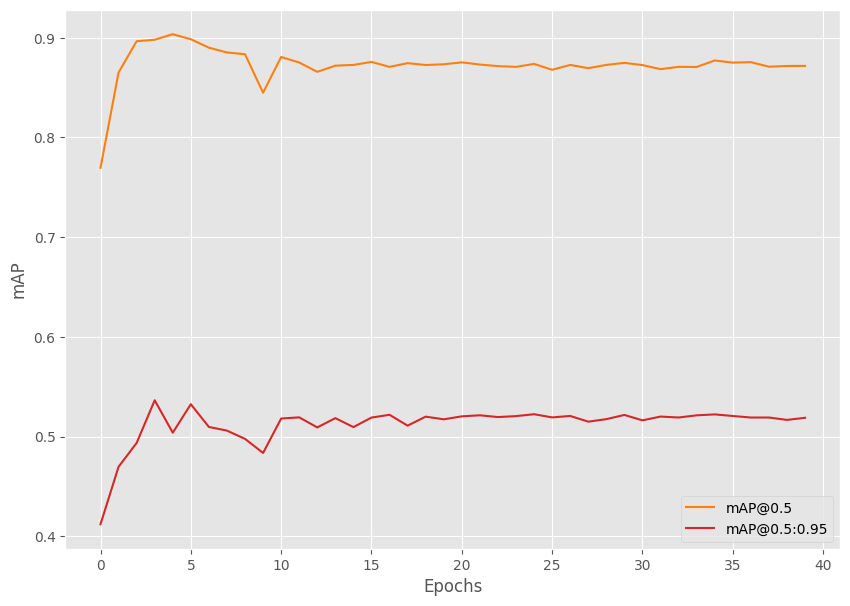

In [ ]:

# To store training loss and mAP values.
train_loss_list = []
#val_loss_list = []
map_50_list = []
map_list = []

# Mame to save the trained model with.
SAVE_PATH = '/content/Defect-Detection/NetDirectory/outputs/best_model.pth'


# To save best model.
save_best_model = SaveBestModel()

metric = MeanAveragePrecision(class_metrics=True)

# Training loop.
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    #train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)

    print(f"Epoch #{epoch+1} train loss: {train_loss:.3f}")

    print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    wandb.log({'epoch': epoch,
               'train_loss': round(train_loss, 2),
               'map_50': metric_summary['map_50'],
               'map': metric_summary['map']}
      )

    wandb.watch(model, log='gradients')


    # save the best model till now.
    save_best_model(
        model, float(metric_summary['map']), epoch, 'outputs'
    )
    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)
    scheduler.step()

model_artifact = wandb.Artifact('FasterRCNN', type = 'model',
                            description = 'FasterRCNN model with resnet_fpn backbone; blur augmentations'
                            )
model_artifact.add_file(SAVE_PATH)

wandb.log_artifact(model_artifact)

In [ ]:
map_img = cv2.imread('/content/Defect-Detection/NetDirectory/outputs/map.png')
loss_img = cv2.imread('/content/Defect-Detection/NetDirectory/outputs/train_loss.png')
cv2_imshow(map_img)
cv2_imshow(loss_img)

# Evaluating the model


In [ ]:
#checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)

checkpoint = torch.load('/content/Defect-Detection/NetDirectory/outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True)
metric_summary = validate(valid_loader, model, metric)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")


Validating


  0%|          | 0/10 [00:00<?, ?it/s]

mAP_50: 89.800
mAP_50_95: 53.639


In [ ]:
VALID_RES_PATH = '/content/val_data.csv'

metric = MeanAveragePrecision(class_metrics=True, iou_thresholds = [0.5])
per_class_stat(valid_loader, model, CLASSES, VALID_RES_PATH, metric)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



{'map': tensor(0.8980), 'map_50': tensor(0.8980), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.5818), 'map_large': tensor(0.9675), 'mar_1': tensor(0.2187), 'mar_10': tensor(0.9246), 'mar_100': tensor(0.9894), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6667), 'mar_large': tensor(0.9839), 'map_per_class': tensor([0.9639, 0.7817, 0.9485]), 'mar_100_per_class': tensor([1.0000, 1.0000, 0.9683]), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


Classes: ['__background__', 'bridge', 'gap', 'sraf']


AP / AR per class
-------------------------------------------------------------------------
|    | Class                | AP                  | AR                  |
-------------------------------------------------------------------------
|1   | bridge               | 0.964               | 1.000               |
|2   | gap                  | 0.782               | 1.000               |
|3   | sraf                 | 0.948               | 0.968               |
---

In [ ]:
TEST_RES_PATH = '/content/test_data.csv'
per_class_stat(test_loader, model, CLASSES, TEST_RES_PATH, metric)

100%|██████████| 4/4 [00:04<00:00,  1.16s/it]



{'map': tensor(0.8852), 'map_50': tensor(0.8852), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.5984), 'map_large': tensor(0.9544), 'mar_1': tensor(0.2193), 'mar_10': tensor(0.9002), 'mar_100': tensor(0.9608), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6667), 'mar_large': tensor(0.9688), 'map_per_class': tensor([0.9636, 0.8323, 0.8596]), 'mar_100_per_class': tensor([1.0000, 1.0000, 0.8824]), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


Classes: ['__background__', 'bridge', 'gap', 'sraf']


AP / AR per class
-------------------------------------------------------------------------
|    | Class                | AP                  | AR                  |
-------------------------------------------------------------------------
|1   | bridge               | 0.964               | 1.000               |
|2   | gap                  | 0.832               | 1.000               |
|3   | sraf                 | 0.860               | 0.882               |
---

If you want to log '.csv' tables  with AP/AR metrics to WandB server run two cells below and then finish run.

In [ ]:
metric_val_artifact = wandb.Artifact('Valid_metric', type = 'metric',
                            description = 'FasterRCNN valid metric with mAP50'
                            )
metric_val_artifact.add_file(VALID_RES_PATH)

wandb.log_artifact(metric_val_artifact)

<Artifact Valid_metric>

In [ ]:
metric_test_artifact = wandb.Artifact('Test_metric', type = 'metric',
                            description = 'FasterRCNN test metric with mAP50'
                            )
metric_test_artifact.add_file(TEST_RES_PATH)

wandb.log_artifact(metric_test_artifact)

<Artifact Test_metric>

In [ ]:
wandb.finish()

Run the cell below if you want to save your model to google drive.

In [ ]:
%cp /content/Defect-Detection/NetDirectory/outputs/faster_rcnn_resnet50_fpnv2.pth /content/drive/MyDrive/models

# Model inference on test data


In [ ]:

test_inference(TEST_DIR,CLASSES, model)

Run the cell below if you want to copy inference outputs to google drive. Previosuly rename the image directory.

In [ ]:
%cp -r /content/Defect-Detection/NetDirectory/inference_outputs/fasterrcnn_mobilenetv3_large_fpn /content/drive/MyDrive/inference_outputs/FasterRCNN

# Load trained model from Weights and Biases


In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('ml_team_mskv/FasterRCNN/FasterRCNN:v9', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact FasterRCNN:v9, 165.41MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.2


In [ ]:
from eval import validate
checkpoint = torch.load('ml_team_mskv/FasterRCNN/FasterRCNN:v9/best.pth, map_location=DEVICE)
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True)
metric_summary = validate(valid_loader, model, metric)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


mAP_50: 89.800
mAP_50_95: 53.639


In [ ]:
from inference import per_class_stat
SAVE_RES_PATH = '/content/data.csv'

per_class_stat(valid_loader, model, CLASSES, SAVE_RES_PATH, metric)

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]




{'map': tensor(0.5364), 'map_50': tensor(0.8980), 'map_75': tensor(0.5667), 'map_small': tensor(-1.), 'map_medium': tensor(0.3157), 'map_large': tensor(0.6726), 'mar_1': tensor(0.1479), 'mar_10': tensor(0.6155), 'mar_100': tensor(0.6488), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.4047), 'mar_large': tensor(0.7444), 'map_per_class': tensor([0.5438, 0.4032, 0.6622]), 'mar_100_per_class': tensor([0.6418, 0.5722, 0.7325]), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


Classes: ['__background__', 'bridge', 'gap', 'sraf']


AP / AR per class
-------------------------------------------------------------------------
|    | Class                | AP                  | AR                  |
-------------------------------------------------------------------------
|1   | bridge               | 0.544               | 0.642               |
|2   | gap                  | 0.403               | 0.572               |
|3   | sraf                 | 0.662               | 0.733               |


In [ ]:
run.finish()

# Load model from google drive

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/models/faster_rcnn_resnet50_fpnv2.pth', map_location=DEVICE)
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True)
metric_summary = validate(valid_loader, model, metric)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

# Tuning hyperparameters for second dataset

In [ ]:
import wandb

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'train_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'batch_size' : {
            'values' : [2,3, 4]
            },

        'optimizer' : {
            'values' : ['SGD','Adam']
        },
        'learning_rate': {'distribution': 'uniform',
                          'max': 0.01,
                          'min': 0.00001},
        'epochs' : {'value': 5}
    },
    'description' : 'tuning hyperparameters for second dataset, resnet101 backbone'
    }


In [ ]:
import pprint

pprint.pprint(sweep_config)
os.makedirs('outputs', exist_ok=True)

{'description': 'tuning hyperparameters for second dataset, resnet101 backbone',
 'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'train_loss'},
 'parameters': {'batch_size': {'values': [2, 3, 4]},
                'epochs': {'value': 5},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.01,
                                  'min': 1e-05},
                'optimizer': {'values': ['SGD', 'Adam']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'FasterRCNN')

Create sweep with ID: qp1qpx60
Sweep URL: https://wandb.ai/ml_team_mskv/FasterRCNN/sweeps/qp1qpx60


In [ ]:
def train(train_data_loader, model, optimizer):
    print('Training')
    model.train()


     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    cumm_loss = 0

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        cumm_loss += loss_value

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return cumm_loss/len(train_data_loader)

    #return loss_value

In [ ]:
def tune_param(config=None):
  #global train_loss_hist
  wandb.init(project = 'FasterRCNN', config = config)
  config = wandb.config
  train_dataset = create_train_dataset(TRAIN_DIR)
  train_loader = create_train_loader(train_dataset, num_workers = 2, B_SIZE = config.batch_size)

  model = create_model(num_classes = NUM_CLASSES, pretrained=True, coco_model = True)
  model = model.to(DEVICE)
  params = [p for p in model.parameters() if p.requires_grad]

  # optimizer = torch.optim.SGD(params, lr=config.learning_rate)
  # print(optimizer)

  if config.optimizer == 'SGD':
    optimizer = torch.optim.SGD(params, lr = config.learning_rate, momentum = 0.9)
  elif config.optimizer == 'Adam':
    optimizer = torch.optim.Adam(params, lr = config.learning_rate)
  wandb.watch(model, log= 'all')


  for epoch in range(config.epochs):
      print(f"\nEPOCH {epoch+1} of {config.epochs}")

      # Reset the training loss histories for the current epoch.
      #train_loss_hist.reset()

      # Start timer and carry out training and validation.
      start = time.time()
      train_loss_epoch = train(train_loader, model, optimizer = optimizer)
      print(f"Epoch #{epoch+1} train loss: {train_loss_epoch:.3f}")

      end = time.time()
      print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


      wandb.log({'epoch': epoch,
                'train_loss': round(train_loss_epoch, 2)
                })

  wandb.finish()


In [ ]:
wandb.agent(sweep_id, function = tune_param, count = 7)

wandb: Agent Starting Run: pws0vbog with config:
wandb: 	batch_size: 3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.002673202547903721
wandb: 	optimizer: Adam
wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #1 train loss: 0.858
Took 1.590 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #2 train loss: 0.450
Took 1.622 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #3 train loss: 0.477
Took 1.619 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #4 train loss: 0.439
Took 1.620 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #5 train loss: 0.379
Took 1.620 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▂▂▂▁
epoch,4
train_loss,0.38


wandb: Agent Starting Run: s7d3hsaa with config:
wandb: 	batch_size: 3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.009065454955728443
wandb: 	optimizer: Adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #1 train loss: 3.617
Took 2.429 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #2 train loss: 0.536
Took 1.593 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #3 train loss: 0.476
Took 1.588 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #4 train loss: 0.435
Took 1.586 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #5 train loss: 0.441
Took 1.581 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▁▁▁▁
epoch,4
train_loss,0.44


wandb: Agent Starting Run: fq5iergc with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0031181256029427997
wandb: 	optimizer: Adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #1 train loss: 1.056
Took 1.710 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #2 train loss: 0.455
Took 1.697 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #3 train loss: 0.457
Took 1.700 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #4 train loss: 0.468
Took 1.692 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #5 train loss: 0.478
Took 3.197 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▁▁▁▁
epoch,4
train_loss,0.48


wandb: Agent Starting Run: esn7505y with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003016251833283095
wandb: 	optimizer: SGD
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #1 train loss: 0.836
Took 1.708 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #2 train loss: 0.526
Took 1.709 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #3 train loss: 0.473
Took 1.710 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #4 train loss: 0.394
Took 1.709 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #5 train loss: 0.369
Took 1.716 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
epoch,4
train_loss,0.37


wandb: Agent Starting Run: 3eel2nva with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.004768588206104578
wandb: 	optimizer: SGD
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.finish()

In [ ]:
#in case the tuning work corrupts or you want to resume the sweep
#just provide the sweep_id which includes user name, project name and id
#then launch wandb agent with corresponding sweep_id
sweep_id = 'ml_team_mskv/FasterRCNN/qp1qpx60'
wandb.agent(sweep_id, function = tune_param, count = 6)

wandb: Agent Starting Run: s1gk0xck with config:
wandb: 	batch_size: 3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.009474383969912311
wandb: 	optimizer: SGD
wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 272MB/s]



EPOCH 1 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #1 train loss: 0.855
Took 1.638 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #2 train loss: 0.472
Took 1.627 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #3 train loss: 0.404
Took 1.618 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #4 train loss: 0.385
Took 1.619 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #5 train loss: 0.351
Took 1.619 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
epoch,4
train_loss,0.35


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cc2az2e4 with config:
wandb: 	batch_size: 4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0072692356177191456
wandb: 	optimizer: Adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #1 train loss: 6.198
Took 1.568 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #2 train loss: 0.530
Took 1.562 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #3 train loss: 0.479
Took 1.556 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #4 train loss: 0.477
Took 1.558 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #5 train loss: 0.504
Took 3.060 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▁▁▁▁
epoch,4
train_loss,0.5


wandb: Agent Starting Run: v4rw2ynr with config:
wandb: 	batch_size: 4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001052319466868514
wandb: 	optimizer: SGD
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #1 train loss: 1.089
Took 1.618 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #2 train loss: 0.662
Took 1.634 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #3 train loss: 0.613
Took 1.636 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #4 train loss: 0.582
Took 1.628 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #5 train loss: 0.542
Took 1.630 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▃▂▂▁
epoch,4
train_loss,0.54


wandb: Agent Starting Run: vwqfitaq with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001082885041841476
wandb: 	optimizer: SGD
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #1 train loss: 1.514
Took 1.704 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #2 train loss: 0.862
Took 1.707 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #3 train loss: 0.771
Took 1.704 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #4 train loss: 0.727
Took 1.706 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #5 train loss: 0.693
Took 1.876 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▂▂▁▁
epoch,4
train_loss,0.69


wandb: Agent Starting Run: pzohb7x4 with config:
wandb: 	batch_size: 3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.004303258276592033
wandb: 	optimizer: SGD
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #1 train loss: 0.859
Took 1.634 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #2 train loss: 0.574
Took 1.631 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #3 train loss: 0.487
Took 1.630 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #4 train loss: 0.415
Took 1.625 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch #5 train loss: 0.394
Took 1.626 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▄▂▁▁
epoch,4
train_loss,0.39


wandb: Agent Starting Run: q1au8pop with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.008501535362471448
wandb: 	optimizer: SGD
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



EPOCH 1 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #1 train loss: 0.852
Took 1.690 minutes for epoch 1

EPOCH 2 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #2 train loss: 0.503
Took 1.689 minutes for epoch 2

EPOCH 3 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #3 train loss: 0.410
Took 1.691 minutes for epoch 3

EPOCH 4 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #4 train loss: 0.354
Took 1.683 minutes for epoch 4

EPOCH 5 of 5
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch #5 train loss: 0.310
Took 1.686 minutes for epoch 5


epoch,▁▃▅▆█
train_loss,█▃▂▂▁
epoch,4
train_loss,0.31
